# Drive mounting

In [ ]:
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Importing libraries

In [ ]:
!pip install --upgrade tables

Requirement already up-to-date: tables in /usr/local/lib/python3.7/dist-packages (3.6.1)


In [ ]:
import seaborn as sns
from scipy import stats

In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# 2. Data loading

In [ ]:
train = pd.read_hdf('/content/drive/MyDrive/time-series/retail/train_online_retail.h5')
test = pd.read_hdf('/content/drive/MyDrive/time-series/retail/test_online_retail.h5')

In [ ]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520142 entries, 12 to 541909
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       520142 non-null  int32         
 1   stock_code    520142 non-null  int16         
 2   description   517903 non-null  object        
 3   quantity      520142 non-null  int32         
 4   invoice_date  520142 non-null  datetime64[ns]
 5   price_unit    520142 non-null  float16       
 6   price_total   520142 non-null  float32       
 7   customer_id   520142 non-null  int16         
 8   country       520142 non-null  object        
 9   is_canceled   520142 non-null  bool          
 10  is_test       520142 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(2)
memory usage: 25.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 547229 entries, 0 to 541893
Data columns (total 10 columns):
 

(None, None)

### Lets displaya bit and see what is inside

In [ ]:
time_info='invoice_date'

In [ ]:
def gen_time_features(orders, time_info):

  orders["date"] = orders[time_info].astype("datetime64")
  orders['year'] = orders['date'].dt.year
  orders['month'] = orders['date'].dt.month
  orders['weekday'] = orders['date'].dt.weekday
  orders['hour'] = orders['date'].dt.hour
  orders['week'] = orders['date'].dt.isocalendar().week
  return orders

In [ ]:
train= gen_time_features(train, time_info)

In [ ]:
train.sample(7)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test,date,year,month,weekday,hour,week
457779,50328,3907,REGENCY CAKESTAND 3 TIER,4,2011-11-11 10:19:00,12.750000,51.00,1218,France,False,False,2011-11-11 10:19:00,2011,11,4,10,45
271220,41685,4587,FRIDGE MAGNETS LA VIE EN ROSE,12,2011-07-20 11:38:00,0.850098,10.20,4118,United Kingdom,False,False,2011-07-20 11:38:00,2011,7,2,11,29
86397,31668,2801,GLASS JAR ENGLISH CONFECTIONERY,2,2011-02-09 16:52:00,5.789062,11.58,-1,United Kingdom,False,False,2011-02-09 16:52:00,2011,2,2,16,6
174399,36519,4639,QUEENS GUARD COFFEE MUG,6,2011-05-04 11:39:00,2.550781,15.30,912,United Kingdom,False,False,2011-05-04 11:39:00,2011,5,2,11,18
296607,43011,4332,FRENCH BLUE METAL DOOR SIGN 4,10,2011-08-10 14:55:00,1.250000,12.50,745,United Kingdom,False,False,2011-08-10 14:55:00,2011,8,2,14,32
188432,37265,4382,METAL DECORATION NAUGHTY CHILDREN,2,2011-05-12 20:13:00,0.850098,1.70,4499,United Kingdom,False,False,2011-05-12 20:13:00,2011,5,3,20,19
492024,51703,1280,BROCADE RING PURSE,36,2011-11-22 16:47:00,0.389893,14.04,5875,United Kingdom,False,False,2011-11-22 16:47:00,2011,11,1,16,47


In [ ]:
train.groupby('customer_id').mean()

,invoice,stock_code,quantity,price_unit,price_total,is_canceled,is_test,year,month,weekday,hour,week
customer_id,,,,,,,,,,,,
-1,28408.608052,1990.442781,6.757912,9.546875,15.439903,0.002728,0.0,2010.443434,7.313083,1.905794,13.580860,29.755380
0,33053.142857,2210.809524,13.380952,42.062500,59.615238,0.380952,0.0,2010.952381,3.047619,3.047619,14.095238,11.952381
1,26465.803279,1660.275956,15.183060,4.066406,35.301529,0.081967,0.0,2010.327869,7.822404,2.412568,12.579235,32.133880
2,8423.950000,605.225000,9.200000,3.611328,15.327000,0.000000,0.0,2009.425000,10.725000,2.275000,9.425000,43.900000
3,27627.415663,2302.016064,159.588353,4.144531,541.268982,0.006024,0.0,2010.417671,7.542169,1.953815,12.985944,30.630522
...,...,...,...,...,...,...,...,...,...,...,...,...
5930,53196.000000,3195.303030,19.454545,0.585449,9.473333,0.000000,0.0,2011.000000,12.000000,1.000000,11.000000,49.000000
5935,53292.000000,2315.041667,10.000000,2.451172,7.026250,0.000000,0.0,2011.000000,12.000000,1.000000,17.000000,49.000000
5936,53342.500000,5182.000000,385.000000,8.328125,2024.250000,0.000000,0.0,2011.000000,12.000000,2.000000,12.000000,49.000000


In [ ]:
train.groupby('customer_id').sum()

,invoice,stock_code,quantity,price_unit,price_total,is_canceled,is_test,year,month,weekday,hour,week
customer_id,,,,,,,,,,,,
-1,3.176026e+09,222527522.0,755521.0,inf,1.726150e+06,305,0,224763555,817588,213064,1518313,3326592
0,6.941160e+05,46427.0,281.0,883.500000,1.251920e+03,8,0,42230,64,64,296,251
1,9.686484e+06,607661.0,5557.0,1488.000000,1.292036e+04,30,0,735780,2863,883,4604,11761
2,3.369580e+05,24209.0,368.0,144.500000,6.130800e+02,0,0,80377,429,91,377,1756
3,1.375845e+07,1146404.0,79475.0,2064.000000,2.695519e+05,3,0,1001188,3756,973,6467,15254
...,...,...,...,...,...,...,...,...,...,...,...,...
5930,1.755468e+06,105445.0,642.0,19.328125,3.126200e+02,0,0,66363,396,33,363,1617
5935,1.279008e+06,55561.0,240.0,58.812500,1.686300e+02,0,0,48264,288,24,408,1176
5936,1.066850e+05,10364.0,770.0,16.656250,4.048500e+03,0,0,4022,24,4,24,98


In [ ]:
train.groupby('year').mean()

,invoice,stock_code,quantity,price_unit,price_total,customer_id,is_canceled,is_test,month,weekday,hour,week
year,,,,,,,,,,,,
2009,1089.402085,828.524690,10.186714,4.363281,19.205385,309.596100,0.022833,0.0,12.000000,2.191779,13.467924,50.133789
2010,16982.128064,1721.492197,12.431299,5.390625,21.288288,1246.374914,0.020498,0.0,7.326510,2.558513,12.934823,29.636717
2011,42317.291415,2604.843940,12.126052,4.789062,22.531723,1886.198696,0.017418,0.0,7.189698,2.432705,12.957672,29.220905


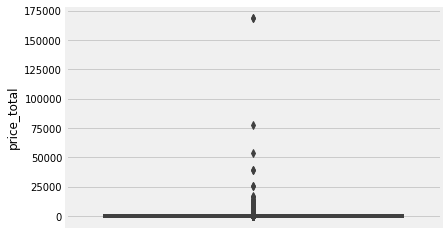

In [ ]:
sns.boxplot(y=train['price_total']);

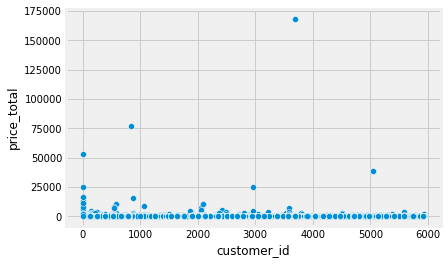

In [ ]:
sns.scatterplot(x = "customer_id", y = "price_total", data = train);

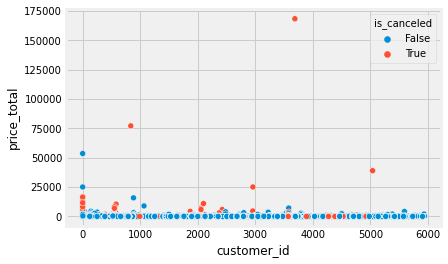

In [ ]:
sns.scatterplot(x = "customer_id", y = "price_total", data = train, hue='is_canceled');

It looks like above 25000 thous there are outliers

https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
https://androidkt.com/detect-and-remove-outliers-from-pandas-dataframe/

In [ ]:
#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
#------------------------------------------------------------------------------
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out



In [ ]:
def remove_outlier(df_in, col_name, low):

    print('percetaile removed below/above --->{}/ {}'.format(low*100, 100-low*100))
    q1 = df_in[col_name].quantile(low)
    q3 = df_in[col_name].quantile(1-low)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    sns.boxplot(y=df_out[col_name]);

    return df_out

percetaile removed below/above --->20.0/ 80.0


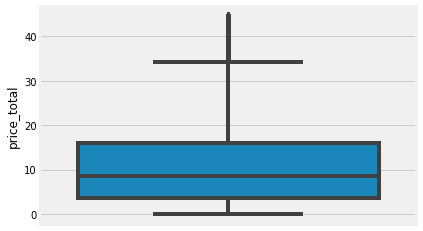

In [ ]:
low= 0.2
col_name='price_total'
train= remove_outlier(train, col_name, low)

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


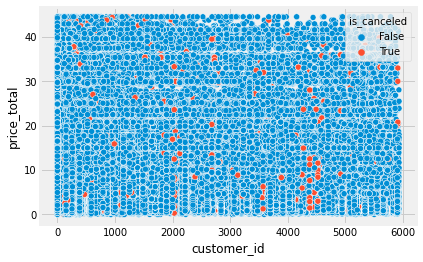

In [ ]:
sns.scatterplot(x = "customer_id", y = "price_total", data = train, hue='is_canceled');

In [ ]:
orders_top = orders[orders['price_total'] >= 25000]
orders_r = orders[orders['price_total'] < 25000]
orders_rr = orders_r[orders_r['customer_id'].isin(regulars)]
orders_rn = orders_r[~orders_r['customer_id'].isin(regulars)]

# 2. Data loading

In [ ]:
def read_and_parse_data(file_name):
    df = pd.read_hdf('/content/drive/MyDrive/time-series/retail/{}'.format(file_name)).reset_index(drop=True)
    df.index = pd.to_datetime( df['invoice_date'] )
    
    return df


train = read_and_parse_data('train_online_retail.h5')
test = read_and_parse_data('test_online_retail.h5')

# 3. Initial looking at the data

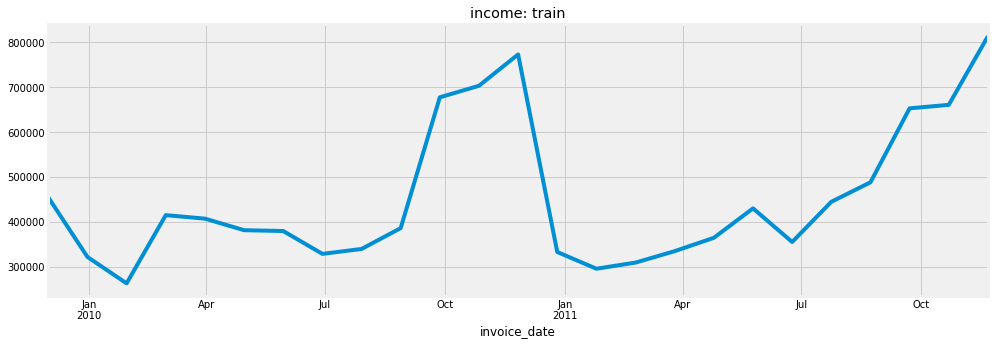

In [ ]:
train.resample('30d').sum()['price_total'].plot(title='income: train', figsize=(15, 5));

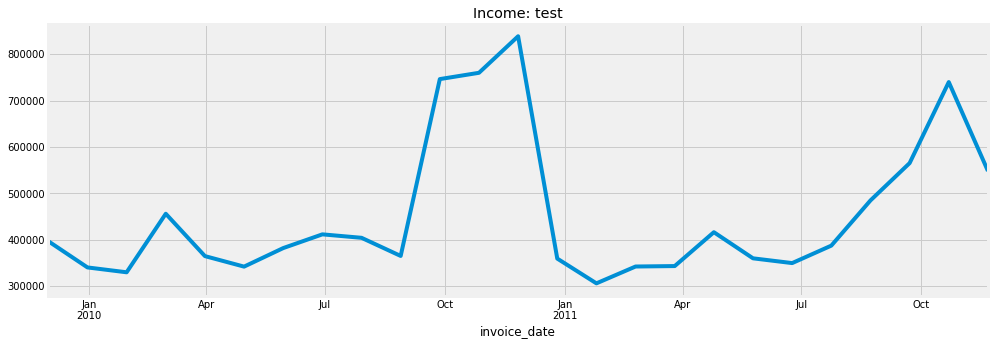

In [ ]:
test.resample('30d').sum()['price_total'].plot(title='Income: test', figsize=(15, 5));

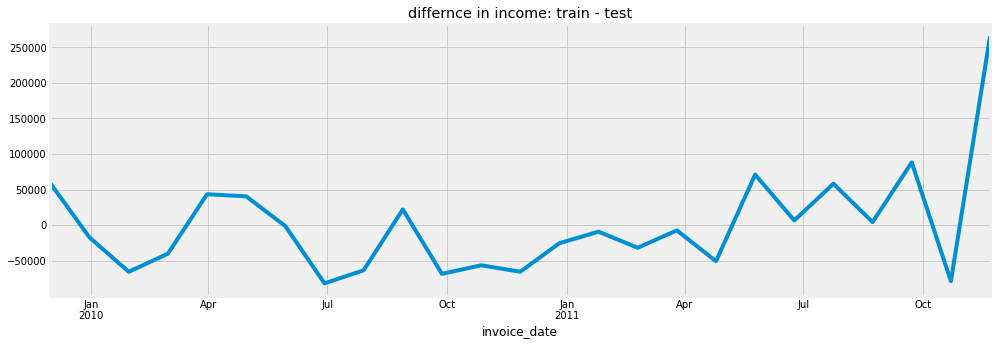

In [ ]:
diff = train.resample('30d').sum()['price_total'] - test.resample('30d').sum()['price_total']
diff.plot(title='differnce in income: train - test', figsize=(15, 5));

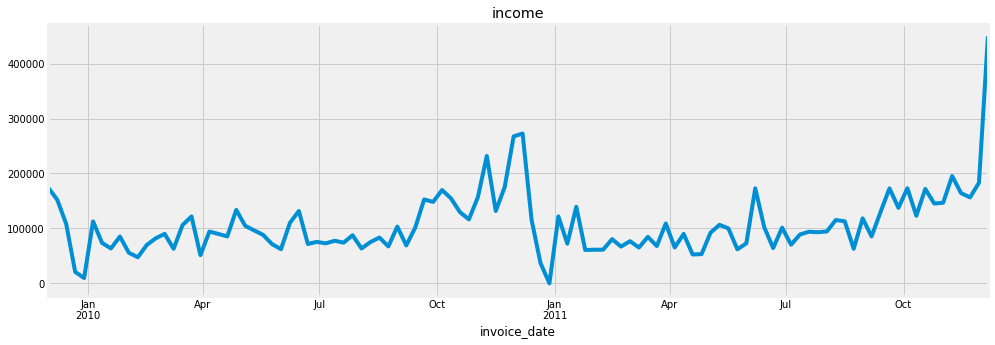

In [ ]:
train.resample('7d').sum()['price_total'].plot(title='income', figsize=(15, 5));

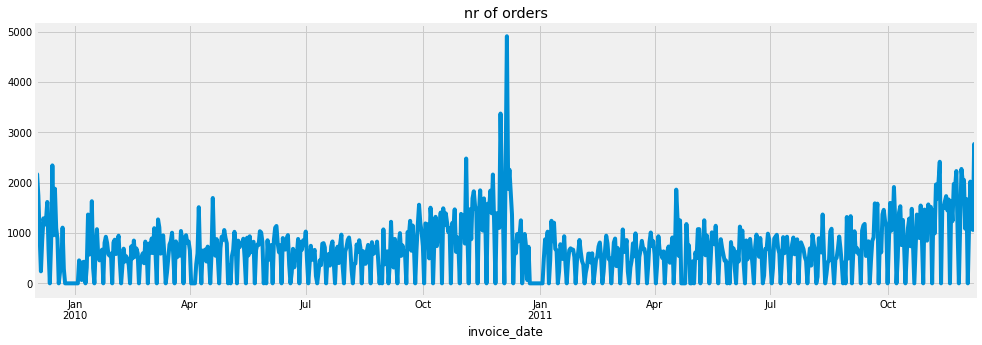

In [ ]:
train.resample('1d').agg(np.size)['price_total'].plot(title='nr of orders', figsize=(15, 5));

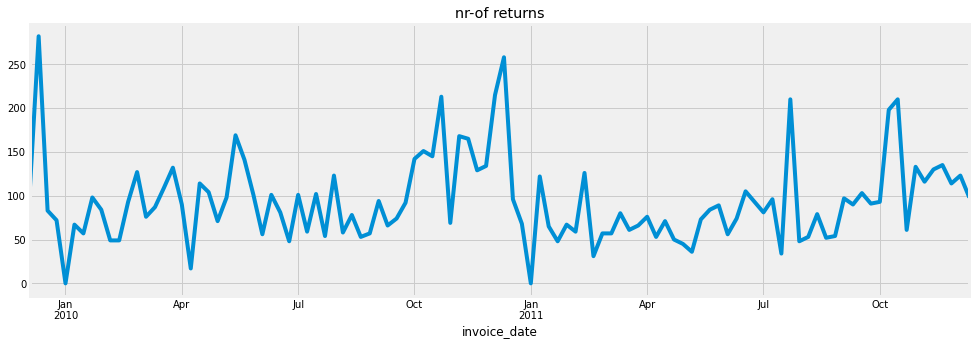

In [ ]:
train[ True == train.is_canceled ].resample('1w').agg(np.size)['price_total'].plot(title='nr-of returns', figsize=(15, 5));

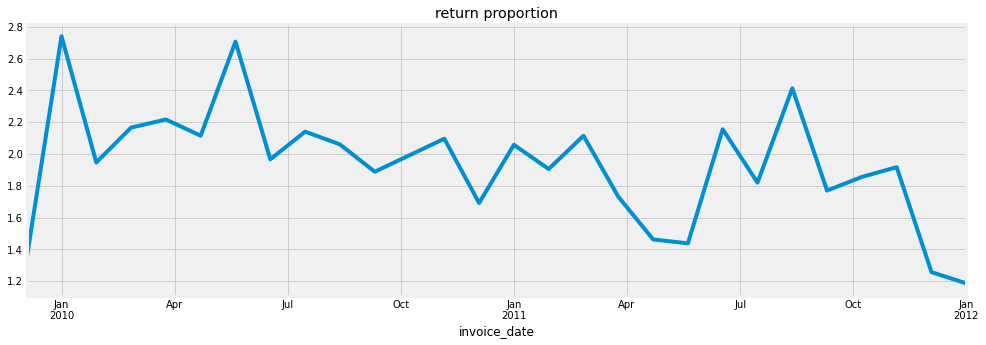

In [ ]:
ratio = train[ True == train.is_canceled ].resample('4w').agg(np.size)['price_total'] / train.resample('4w').agg(np.size)['price_total'] * 100
ratio.plot(title='return proportion', figsize=(15, 5));

# 4. Preprocessing

In [ ]:
train.sample(15)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test
invoice_date,,,,,,,,,,,
2010-02-18 15:44:00,5274,141,JUMBO BAG RED WHITE SPOTTY,10,2010-02-18 15:44:00,1.950195,19.50,949,United Kingdom,False,False
2010-03-09 12:12:00,6646,372,SKULLS WRAP,25,2010-03-09 12:12:00,0.419922,10.50,202,United Kingdom,False,False
2010-01-11 13:51:00,2686,596,SET/20 RED SPOTTY PAPER NAPKINS,1,2010-01-11 13:51:00,0.850098,0.85,573,United Kingdom,False,False
2010-03-18 12:14:00,7228,581,"STRING OF 8 BUTTERFLIES,PINK",4,2010-03-18 12:14:00,1.650391,6.60,2038,United Kingdom,False,False
2011-10-18 14:47:00,47992,4925,SMALL BONNE JAM JAR T-LIGHT HOLDER,6,2011-10-18 14:47:00,2.080078,12.48,5634,United Kingdom,False,False
2010-11-29 13:09:00,27496,111,BATHROOM METAL SIGN,3,2010-11-29 13:09:00,0.549805,1.65,3056,United Kingdom,False,False
2011-06-05 15:25:00,38771,740,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,2011-06-05 15:25:00,0.290039,13.92,1901,United Kingdom,False,False
2010-11-04 08:46:00,24495,142,CHARLOTTE BAG PINK POLKADOT,10,2010-11-04 08:46:00,0.850098,8.50,471,United Kingdom,False,False
2011-01-21 12:37:00,30639,4606,CHILDREN'S CIRCUS PARADE MUG,6,2011-01-21 12:37:00,1.650391,9.90,4455,United Kingdom,False,False


takie cos nie dalo zupelnie nic

In [ ]:
train['ratio'] = train[ True == train.is_canceled ].resample('4w').agg(np.size)['price_total'] / train.resample('4w').agg(np.size)['price_total'] * 100

return propotion prediction lets build some model topredict that

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 520142 entries, 2009-12-01 09:06:00 to 2011-12-09 12:50:00
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       520142 non-null  int32         
 1   stock_code    520142 non-null  int16         
 2   description   517903 non-null  object        
 3   quantity      520142 non-null  int32         
 4   invoice_date  520142 non-null  datetime64[ns]
 5   price_unit    520142 non-null  float16       
 6   price_total   520142 non-null  float32       
 7   customer_id   520142 non-null  int16         
 8   country       520142 non-null  object        
 9   is_canceled   520142 non-null  bool          
 10  is_test       520142 non-null  bool          
 11  ratio         0 non-null       float32       
dtypes: bool(2), datetime64[ns](1), float16(1), float32(2), int16(2), int32(2), object(2)
memory usage: 27.8+ MB


In [ ]:
def dist(df):
    print('detailed')
    print(df.index[:10])
    print( df.is_canceled.value_counts(normalize=True).values * 100)
    
    df_agg = df.groupby('invoice').sum()
    df_agg['is_canceled'] = (df_agg['is_canceled'] > 0).astype(np.int)

    print('orders')
    print(df_agg['is_canceled'].value_counts(normalize=True).values * 100)

In [ ]:
dist(train)

detailed
DatetimeIndex(['2009-12-01 09:06:00', '2009-12-01 09:06:00',
               '2009-12-01 09:06:00', '2009-12-01 09:06:00',
               '2009-12-01 09:06:00', '2009-12-01 09:06:00',
               '2009-12-01 09:06:00', '2009-12-01 09:06:00',
               '2009-12-01 09:06:00', '2009-12-01 09:06:00'],
              dtype='datetime64[ns]', name='invoice_date', freq=None)
[98.0837925  1.9162075]
orders
[84.53792795 15.46207205]


In [ ]:
train_agg = train.groupby('invoice')[ ['price_total',  'is_canceled'] ].sum()
train_agg['is_canceled'] = train_agg['is_canceled'] > 0
train_agg['total_return'] = train_agg['price_total'] * train_agg['is_canceled']

In [ ]:
train_agg.sample(7)

,price_total,is_canceled,total_return
invoice,,,
53414,312.220001,False,0.0
29237,571.479980,False,0.0
52693,385.300018,False,0.0
22836,0.000000,False,0.0
47078,439.559998,False,0.0
5114,179.679993,False,0.0
24709,500.000000,False,0.0


In [ ]:
new= pd.merge(train, train_agg, left_on='invoice', right_on='invoice')

In [ ]:
new.sample(7).T

,252214,192043,201748,22714,92808,114577,100363
invoice,27996,22287,23274,2105,10271,13162,11394
stock_code,220,1303,752,1083,176,501,542
description,PINK CREAM FELT CRAFT TRINKET BOX,CREAM CUPID HEARTS COAT HANGER,NaN,SET/3 VANILLA SCENTED CANDLE IN BOX,SET 10 LIGHTS NIGHT OWL,WHITE DOVE HONEYCOMB PAPER GARLAND,LOLITA DESIGN COTTON TOTE BAG
quantity,12,8,128,1,2,1,1
invoice_date,2010-12-02 16:38:00,2010-10-13 12:00:00,2010-10-22 11:30:00,2009-12-22 09:52:00,2010-05-04 11:51:00,2010-06-07 16:39:00,2010-05-16 12:51:00
price_unit,1.25,3.25,0,8.64844,6.75,1.65039,2.25
price_total_x,15,26,0,8.65,13.5,1.65,2.25
customer_id,4350,844,-1,-1,7,252,202
country,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom
is_canceled_x,False,False,False,False,False,False,False


In [ ]:
new[new["invoice"]==2178]

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total_x,customer_id,country,is_canceled_x,is_test,price_total_y,is_canceled_y,total_return
22924,2178,271,GLITTER STAR GARLAND WITH BELLS,1,2009-12-22 13:08:00,3.750000,3.75,160,United Kingdom,True,False,68.139999,True,68.139999
22925,2178,745,PAINTED METAL TREE WITH HOLLY BELLS,3,2009-12-22 13:08:00,1.450195,4.35,160,United Kingdom,True,False,68.139999,True,68.139999
22926,2178,785,HEART GARLAND RUSTIC PADDED,1,2009-12-22 13:08:00,2.949219,2.95,160,United Kingdom,True,False,68.139999,True,68.139999
22927,2178,1348,CHRISTMAS TREE PAINTED ZINC,1,2009-12-22 13:08:00,0.649902,0.65,160,United Kingdom,True,False,68.139999,True,68.139999
22928,2178,725,WHITE CHRISTMAS STAR DECORATION,1,2009-12-22 13:08:00,0.419922,0.42,160,United Kingdom,True,False,68.139999,True,68.139999
22929,2178,280,HEART DECORATION PAINTED ZINC,1,2009-12-22 13:08:00,0.649902,0.65,160,United Kingdom,True,False,68.139999,True,68.139999
22930,2178,359,ANGEL DECORATION 3 BUTTONS,1,2009-12-22 13:08:00,0.419922,0.42,160,United Kingdom,True,False,68.139999,True,68.139999
22931,2178,1348,CHRISTMAS TREE PAINTED ZINC,2,2009-12-22 13:08:00,0.649902,1.30,160,United Kingdom,True,False,68.139999,True,68.139999
22932,2178,351,CAKE PLATE LOVEBIRD WHITE,1,2009-12-22 13:08:00,4.949219,4.95,160,United Kingdom,True,False,68.139999,True,68.139999
22933,2178,1905,BEADED PEARL HEART WHITE ON STICK,1,2009-12-22 13:08:00,1.250000,1.25,160,United Kingdom,True,False,68.139999,True,68.139999


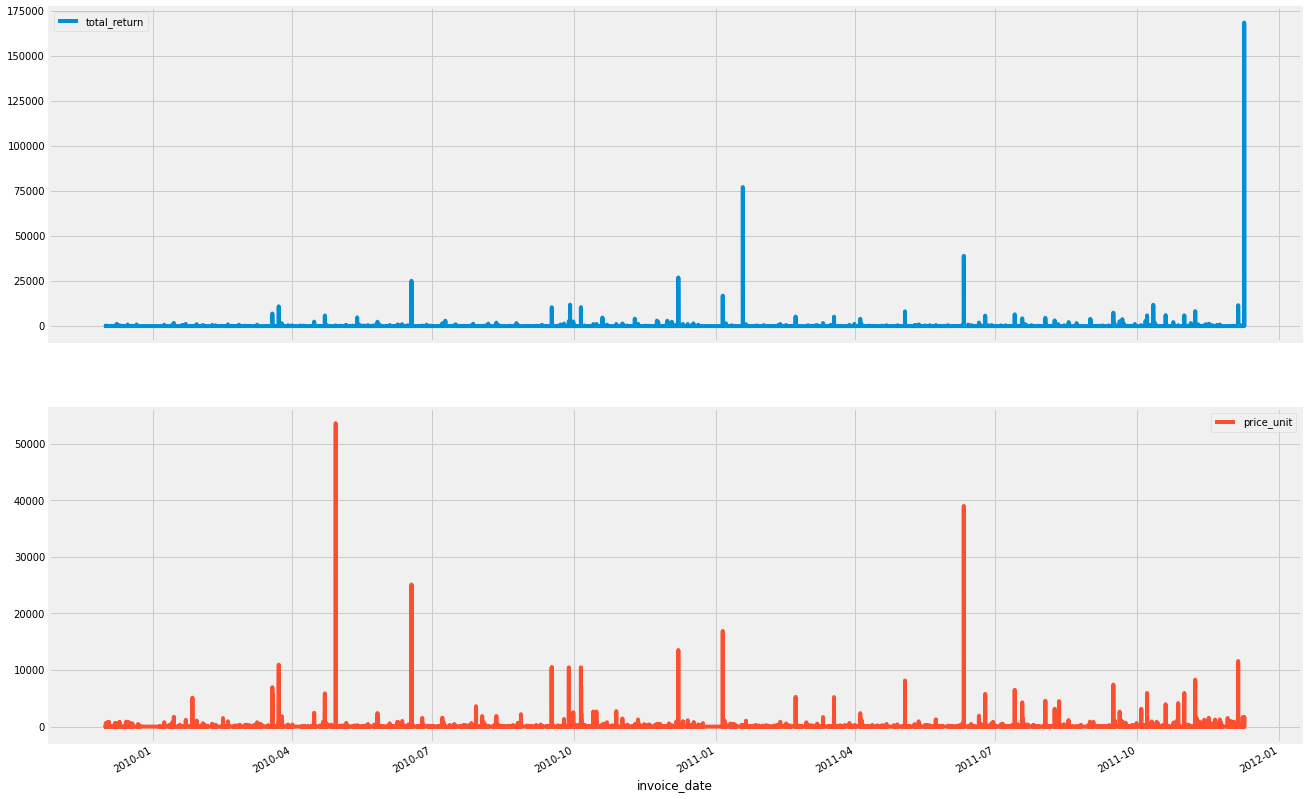

In [ ]:
new[['invoice_date','total_return', 'price_unit']].plot(x='invoice_date', subplots=True, figsize=(20,15))
plt.show()

Counting (ratio _stock_code_rat_, number _stock_code_canc_) canceled articles

In [ ]:
stock_code_num = dict(train['stock_code'].value_counts())
stock_code_canc =  dict(train[train['is_canceled'] == True]['stock_code'].value_counts())

stock_code_rat = {}

for key in stock_code_num:
    if key not in stock_code_canc:
        stock_code_canc[key] = 0
        stock_code_rat[key] = 0
    else:
        stock_code_rat[key] = stock_code_canc[key]/stock_code_num[key]
        
mean_canc = np.mean(list(stock_code_canc.values()))
mean_rat = np.mean(list(stock_code_rat.values()))

stock_code_canc = defaultdict(lambda: mean_canc, stock_code_canc)
stock_code_rat = defaultdict(lambda: mean_rat, stock_code_rat)

In [ ]:
mean_canc, mean_rat 

(1.9752279032897344, 0.021590560689142703)

In [ ]:
stock_code_rat

In [ ]:
train['stock_code_rat'] = train['stock_code'].map(stock_code_rat)
train['stock_code_canc'] = train['stock_code'].map(stock_code_canc)

In [ ]:
train.sample(7).T

invoice_date,2010-01-20 11:57:00,2010-11-23 16:53:00,2010-01-14 13:02:00,2010-11-01 15:05:00,2011-11-29 17:52:00,2010-02-21 15:19:00,2010-05-07 12:56:00
invoice,3145,26828,2864,24131,52443,5400,10624
stock_code,771,3841,182,562,4852,1248,342
description,72 SWEETHEART FAIRY CAKE CASES,SET OF 2 WOODEN MARKET CRATES,RED STRIPE CERAMIC DRAWER KNOB,DOORMAT WELCOME PUPPIES,WHITE ROCKING HORSE HAND PAINTED,RED DINER WALL CLOCK,POTTING SHED TEA MUG
quantity,6,1,12,2,6,2,12
invoice_date,2010-01-20 11:57:00,2010-11-23 16:53:00,2010-01-14 13:02:00,2010-11-01 15:05:00,2011-11-29 17:52:00,2010-02-21 15:19:00,2010-05-07 12:56:00
price_unit,0.549805,25.4844,1.25,7.94922,1.25,8.5,1.25
price_total,3.3,25.49,15,15.9,7.5,17,15
customer_id,1235,-1,1158,4021,202,230,459
country,United Kingdom,United Kingdom,Germany,United Kingdom,United Kingdom,United Kingdom,United Kingdom
is_canceled,False,False,False,False,False,False,False


# 5. Features generation per an invoice

In [ ]:
orders = train.groupby('invoice').agg(
    num_canceled=('is_canceled', sum), item_num=('price_total', 'count'),
    price_total=('price_total', sum), m_expensive_item_total=('price_total', max),
    item_median_total=('price_total', np.median), l_expensive_item_total=('price_total', min),
    sum_quant=('quantity', sum), great_quant=('quantity', max), least_quent=('quantity', min),
    date=('invoice_date', 'first'), country=('country', 'first'),
    customer_id=('customer_id', 'first'),
    mean_scrat=('stock_code_rat', np.mean), min_scrat=('stock_code_rat', min),
    max_scrat=('stock_code_rat', max),
    mean_sccanc=('stock_code_canc', np.mean), min_sccanc=('stock_code_canc', min),
    max_sccanc=('stock_code_canc', max))

# Time features

orders["date"] = orders['date'].astype("datetime64")
orders['year'] = orders['date'].dt.year
orders['month'] = orders['date'].dt.month
orders['weekday'] = orders['date'].dt.weekday
orders['hour'] = orders['date'].dt.hour


orders['is_canceled'] = orders['num_canceled'] > 0
orders['total_return'] = orders['price_total'] * orders['is_canceled']

orders['country_val'] = pd.factorize(orders['country'])[0]

In [ ]:
orders['week'] = orders['date'].dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [ ]:
orders.sample(10).T

invoice,41522,41874,38686,51391,16290,44098,38833,45798,27714,37506
num_canceled,1,0,0,0,0,5,0,0,0,1
item_num,1,41,47,78,11,5,31,1,9,1
price_total,2.95,748.14,1109.32,341.24,68.8,42.4,394.14,0,376.5,40.56
m_expensive_item_total,2.95,89.1,102,25,18,15,23.4,0,100.8,40.56
item_median_total,2.95,15.9,19.8,2.925,3.9,9.95,14.85,0,22.5,40.56
l_expensive_item_total,2.95,0.42,10.2,0.42,1.7,3.75,5.04,0,16.8,40.56
sum_quant,1,346,356,261,21,6,446,5,158,24
great_quant,1,36,24,36,2,2,36,5,48,24
least_quent,1,1,1,1,1,1,3,5,6,24
date,2011-07-18 13:20:00,2011-07-22 13:20:00,2011-06-03 12:26:00,2011-11-20 14:07:00,2010-07-22 16:37:00,2011-08-31 12:26:00,2011-06-06 13:47:00,2011-09-22 17:21:00,2010-11-30 16:37:00,2011-05-17 12:10:00


### looking from time perspective

In [ ]:
  df = orders.reset_index(drop=True)
  df.index = pd.to_datetime( df['date'] )
    

In [ ]:
df.resample('30d')['price_total'].plot(title='income: train', figsize=(15, 5));

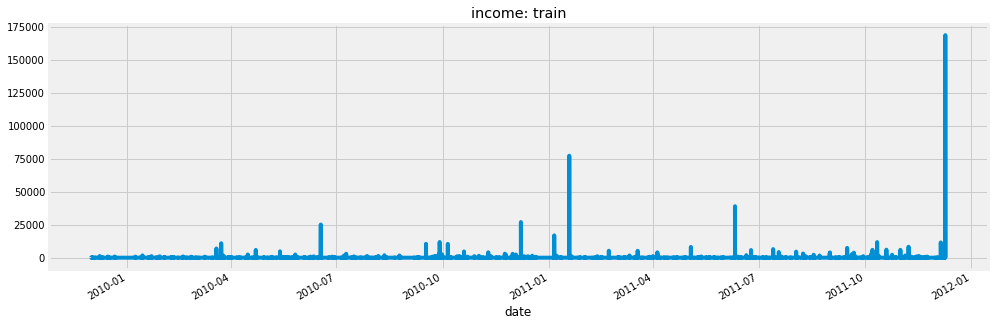

In [ ]:
df['total_return'].plot(title='income: train', figsize=(15, 5));

In [ ]:
df.total_return.value_counts()

0.000000      22668
4.950000         71
12.750000        62
9.950000         60
8.500000         59
              ...  
34.900002         1
111.300003        1
247.440002        1
6.760000          1
48.329998         1
Name: total_return, Length: 1827, dtype: int64

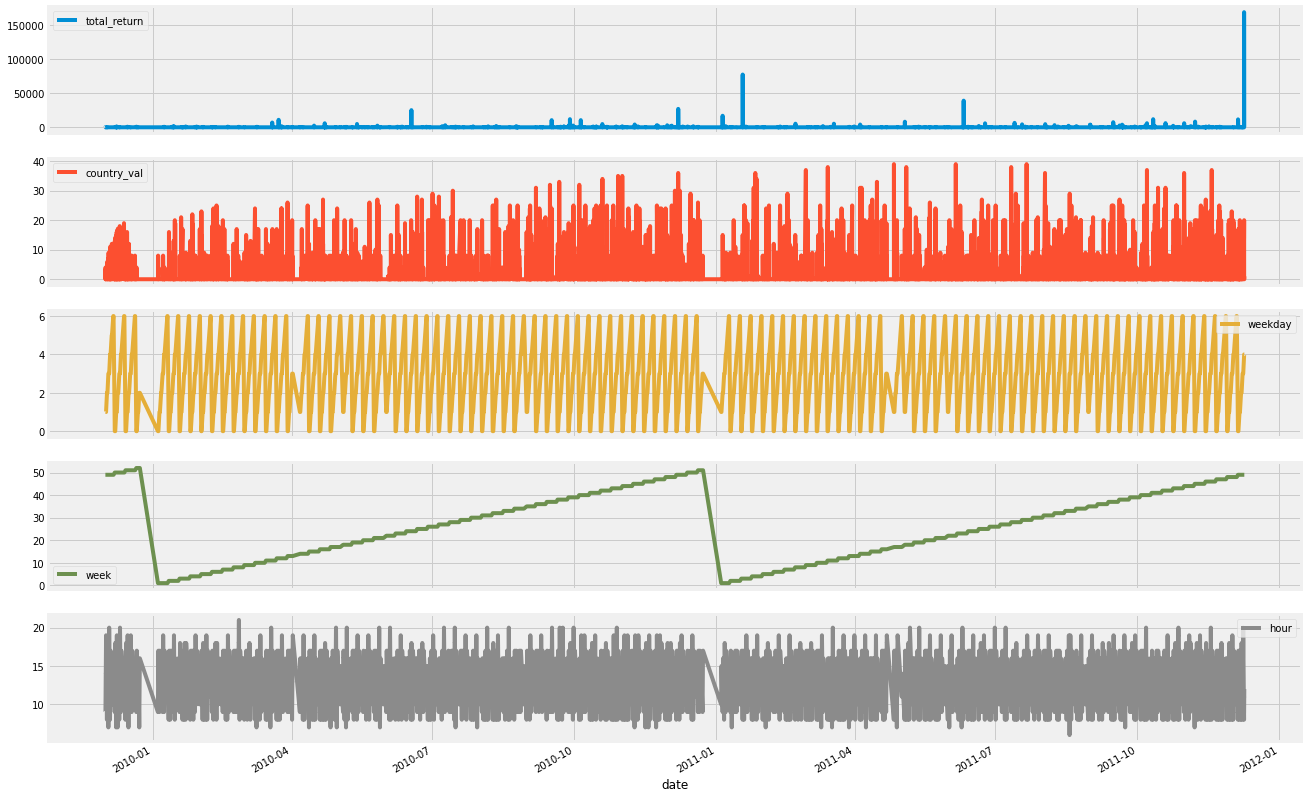

In [ ]:
orders[['date','total_return', 'country_val', 'weekday', 'week', 'hour' ]].plot(x='date', subplots=True, figsize=(20,15))
plt.show()

In [ ]:
customers = orders.groupby('customer_id').agg(invoices=('price_total', 'count'), returns=('is_canceled', sum))
regulars = customers[customers['invoices'] > 19].index

In [ ]:
customers.sample(7)

,invoices,returns,item_count
customer_id,,,
598,4,1,48
5088,5,1,41
1800,3,0,46
5317,1,0,21
5233,2,1,8
3710,3,0,45
2072,3,1,20


In [ ]:
customers = orders.groupby('customer_id').agg(invoices=('price_total', 'count'), returns=('is_canceled', sum), item_count=('item_num', , item_count=('item_num', sum))

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
bb

In [ ]:
bbb

In [ ]:
bb